## Fit AuotoARIMA

In [1]:
import pandas as pd


# Load the dataset
file_path = 'MS_31285_POD_916_CPU.csv'
data = pd.read_csv(file_path, parse_dates=True)

# Convert the timestamp to the desired format
# Start date is 01/01/2022
start_date = pd.Timestamp('2022-01-01')

# Convert the timestamp from milliseconds to seconds and add it to the start date
data['timestamp'] = data['timestamp'].apply(lambda x: start_date + pd.Timedelta(seconds=x/1000))


# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['timestamp', 'cpu_utilization']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'cpu_utilization': 'y', 'timestamp': 'ds'})

#Resample to hours
cpu_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(cpu_usage_dataset_with_corrected_timestamp['ds'])
cpu_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.resample('H').mean()

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.reset_index()


cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'MS_31285_POD_916_CPU'

cpu_usage_dataset_with_corrected_timestamp = cpu_usage_dataset_with_corrected_timestamp.tail(7*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
336,2022-01-15 00:00:00,0.421766,MS_31285_POD_916_CPU
337,2022-01-15 01:00:00,0.340540,MS_31285_POD_916_CPU
338,2022-01-15 02:00:00,0.305308,MS_31285_POD_916_CPU
339,2022-01-15 03:00:00,0.285982,MS_31285_POD_916_CPU
340,2022-01-15 04:00:00,0.305947,MS_31285_POD_916_CPU
...,...,...,...
499,2022-01-21 19:00:00,0.499440,MS_31285_POD_916_CPU
500,2022-01-21 20:00:00,0.511047,MS_31285_POD_916_CPU
501,2022-01-21 21:00:00,0.511609,MS_31285_POD_916_CPU
502,2022-01-21 22:00:00,0.500556,MS_31285_POD_916_CPU


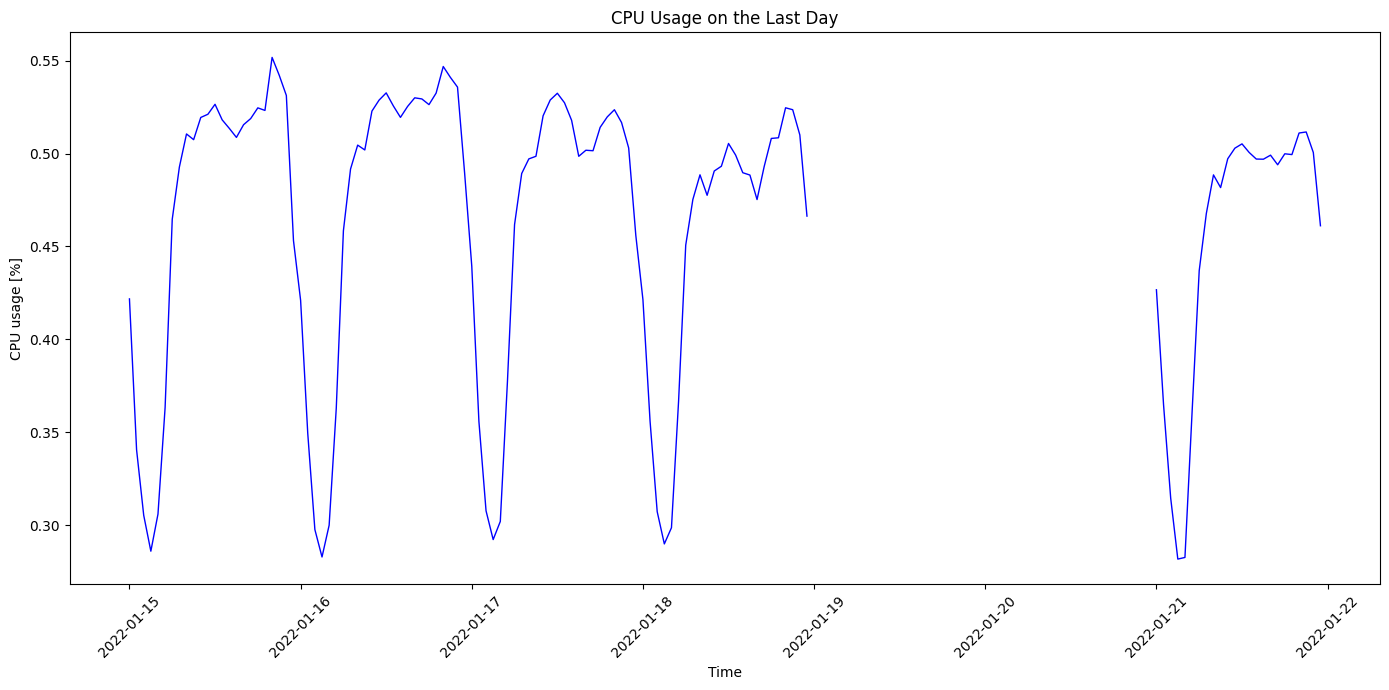

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(cpu_usage_dataset_with_corrected_timestamp['ds'], cpu_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('CPU Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('CPU usage [%]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H',
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=24,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/arima.py:1740: UserWarning: The chosen seasonal unit root test encountered an error when testing for the 0 difference.
From seas(): `mstl` cannot handle missing values. Please raise an issue to include this feature.
0 seasonal differences will be used. Consider using a different unit root test.
  warnings.warn(
/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,
MS_31285_POD_916_CPU,2022-01-21 00:00:00,2022-01-20 23:00:00,0.426682,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 01:00:00,2022-01-20 23:00:00,0.364816,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 02:00:00,2022-01-20 23:00:00,0.314585,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 03:00:00,2022-01-20 23:00:00,0.281737,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 04:00:00,2022-01-20 23:00:00,0.282618,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 05:00:00,2022-01-20 23:00:00,0.360760,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 06:00:00,2022-01-20 23:00:00,0.436975,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 07:00:00,2022-01-20 23:00:00,0.467759,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MS_31285_POD_916_CPU,2022-01-21 08:00:00,2022-01-20 23:00:00,0.488507,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


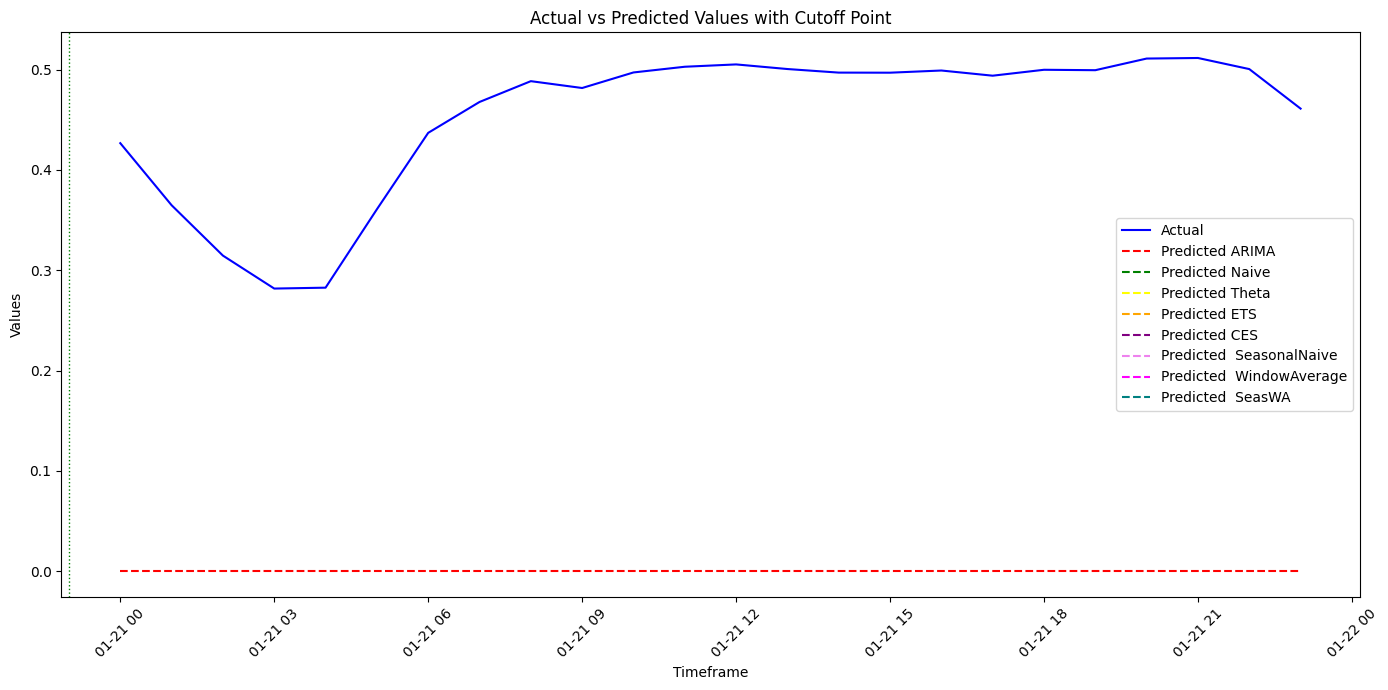

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(cpu_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
df_cv = cross_validation(model, horizon='2 days', initial='3 days')

  0%|          | 0/1 [00:00<?, ?it/s]

16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:31 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-21 00:00:00,0.371708,0.359554,0.383775,0.426682,2022-01-19 23:00:00
1,2022-01-21 01:00:00,0.301330,0.288102,0.313732,0.364816,2022-01-19 23:00:00
2,2022-01-21 02:00:00,0.245171,0.232302,0.257190,0.314585,2022-01-19 23:00:00
3,2022-01-21 03:00:00,0.228497,0.216818,0.240646,0.281737,2022-01-19 23:00:00
4,2022-01-21 04:00:00,0.259573,0.247281,0.272461,0.282618,2022-01-19 23:00:00
5,2022-01-21 05:00:00,0.322766,0.310241,0.335951,0.360760,2022-01-19 23:00:00
6,2022-01-21 06:00:00,0.388401,0.376168,0.401072,0.436975,2022-01-19 23:00:00
7,2022-01-21 07:00:00,0.432150,0.419454,0.444375,0.467759,2022-01-19 23:00:00
8,2022-01-21 08:00:00,0.448773,0.436895,0.461243,0.488507,2022-01-19 23:00:00
9,2022-01-21 09:00:00,0.450231,0.437454,0.462418,0.481680,2022-01-19 23:00:00


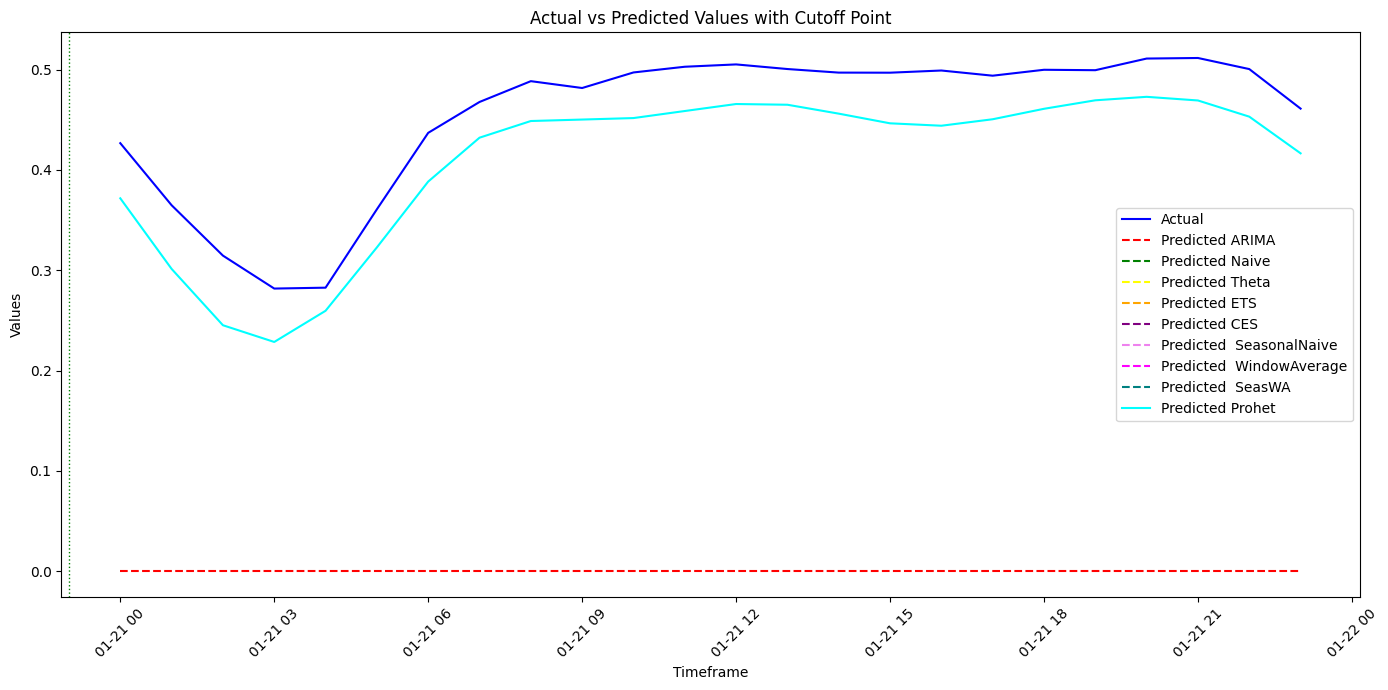

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,MS_31285_POD_916_CPU,2022-01-21 00:00:00,2022-01-20 23:00:00,0.426682,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.371708
1,MS_31285_POD_916_CPU,2022-01-21 01:00:00,2022-01-20 23:00:00,0.364816,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301330
2,MS_31285_POD_916_CPU,2022-01-21 02:00:00,2022-01-20 23:00:00,0.314585,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245171
3,MS_31285_POD_916_CPU,2022-01-21 03:00:00,2022-01-20 23:00:00,0.281737,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.228497
4,MS_31285_POD_916_CPU,2022-01-21 04:00:00,2022-01-20 23:00:00,0.282618,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259573
5,MS_31285_POD_916_CPU,2022-01-21 05:00:00,2022-01-20 23:00:00,0.360760,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322766
6,MS_31285_POD_916_CPU,2022-01-21 06:00:00,2022-01-20 23:00:00,0.436975,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.388401
7,MS_31285_POD_916_CPU,2022-01-21 07:00:00,2022-01-20 23:00:00,0.467759,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.432150
8,MS_31285_POD_916_CPU,2022-01-21 08:00:00,2022-01-20 23:00:00,0.488507,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448773
9,MS_31285_POD_916_CPU,2022-01-21 09:00:00,2022-01-20 23:00:00,0.481680,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450231


In [14]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [15]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,
MS_31285_POD_916_CPU,0.210932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002032,prophet
